# **Loading The Dataset**

In [1]:
import pandas as pd

# Load training data
train_df = pd.read_csv("olid-training-v1.0.tsv", sep="\t")

# Show data preview
train_df.head()


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


# **EDA**

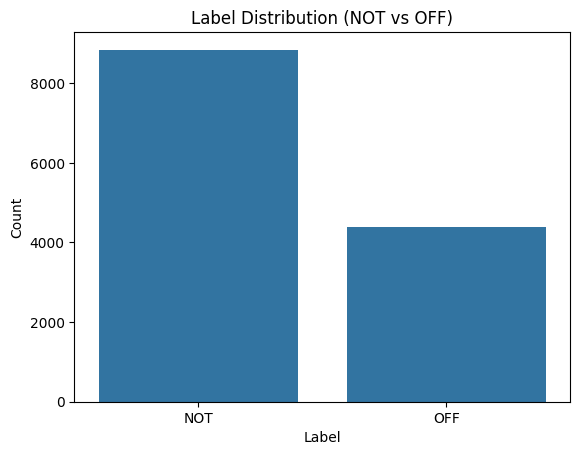

count    13240.000000
mean       125.908459
std         86.625831
min         10.000000
25%         55.000000
50%        102.000000
75%        185.000000
max        580.000000
Name: tweet, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check label distribution
label_counts = train_df['subtask_a'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution (NOT vs OFF)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Print basic stats
print(train_df['tweet'].str.len().describe())

# **Data Preprocessing**

In [3]:
import re
import emoji

# Basic cleaning functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"@USER", "", text)
    text = re.sub(r"URL", "", text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply preprocessing
train_df['clean_tweet'] = train_df['tweet'].apply(clean_text)

# Label encoding
label_map = {'NOT': 0, 'OFF': 1}
train_df['label'] = train_df['subtask_a'].map(label_map)

# Show cleaned sample
train_df[['tweet', 'clean_tweet', 'label']].head()


,tweet,clean_tweet,label
0,@USER She should ask a few native Americans wh...,user she should ask a few native americans wha...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,user user go home youre drunk user maga trump ...,1
2,Amazon is investigating Chinese employees who ...,amazon is investigating chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",user someone shouldvetaken this piece of shit ...,1
4,@USER @USER Obama wanted liberals &amp; illega...,user user obama wanted liberals amp illegals t...,0


# **BERT**

In [4]:
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
import numpy as np

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Set max token length
MAX_LEN = 128


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Encode the cleaned tweets
def tokenize_data(texts, labels):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels)
    ))
    return dataset

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean_tweet"],
    train_df["label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

# Tokenised datasets
train_dataset = tokenize_data(X_train, y_train).shuffle(1024).batch(32)
val_dataset = tokenize_data(X_val, y_val).batch(32)


In [6]:
# Load BERT for binary classification
model_bert = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model_bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [8]:
history = model_bert.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5, # You can increase this for better performance
)

Epoch 1/5
331/331 [==============================] - 367s 915ms/step - loss: 0.5264 - accuracy: 0.7454 - val_loss: 0.4803 - val_accuracy: 0.7730
Epoch 2/5
331/331 [==============================] - 281s 850ms/step - loss: 0.4232 - accuracy: 0.8087 - val_loss: 0.5090 - val_accuracy: 0.7889
Epoch 3/5
331/331 [==============================] - 281s 849ms/step - loss: 0.3459 - accuracy: 0.8483 - val_loss: 0.5393 - val_accuracy: 0.7421
Epoch 4/5
331/331 [==============================] - 281s 849ms/step - loss: 0.2646 - accuracy: 0.8931 - val_loss: 0.5965 - val_accuracy: 0.7606
Epoch 5/5
331/331 [==============================] - 281s 849ms/step - loss: 0.1770 - accuracy: 0.9336 - val_loss: 0.6825 - val_accuracy: 0.7625


In [ ]:
# Get predictions
y_preds = model_bert.predict(val_dataset)["logits"]
y_pred_classes = np.argmax(y_preds, axis=1)

# Print metrics
print(classification_report(y_val, y_pred_classes, target_names=["NOT", "OFF"]))
print("Macro F1 Score:", f1_score(y_val, y_pred_classes, average='macro'))


83/83 [==============================] - 29s 274ms/step
              precision    recall  f1-score   support

         NOT       0.84      0.83      0.84      1768
         OFF       0.67      0.69      0.68       880

    accuracy                           0.79      2648
   macro avg       0.76      0.76      0.76      2648
weighted avg       0.79      0.79      0.79      2648

Macro F1 Score: 0.7598987920386524


# **RoBERTa**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Load tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
# Tokenisation function
def tokenize_roberta(texts, labels):
    encodings = roberta_tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels)
    ))
    return dataset

# Create train and validation datasets
train_dataset_roberta = tokenize_roberta(X_train, y_train).shuffle(1024).batch(32)
val_dataset_roberta = tokenize_roberta(X_val, y_val).batch(32)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

roberta_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [ ]:
history_roberta = roberta_model.fit(
    train_dataset_roberta,
    validation_data=val_dataset_roberta,
    epochs=3  # Adjust as needed
)


Epoch 1/3
331/331 [==============================] - 332s 865ms/step - loss: 0.4848 - accuracy: 0.7759 - val_loss: 0.4389 - val_accuracy: 0.8032
Epoch 2/3
331/331 [==============================] - 275s 830ms/step - loss: 0.3980 - accuracy: 0.8267 - val_loss: 0.4815 - val_accuracy: 0.7753
Epoch 3/3
331/331 [==============================] - 274s 829ms/step - loss: 0.3350 - accuracy: 0.8564 - val_loss: 0.5023 - val_accuracy: 0.7983


In [ ]:
# Predict
y_pred_roberta_logits = roberta_model.predict(val_dataset_roberta)["logits"]
y_pred_roberta = np.argmax(y_pred_roberta_logits, axis=1)

# Metrics
print(classification_report(y_val, y_pred_roberta, target_names=["NOT", "OFF"]))
print("Macro F1 Score:", f1_score(y_val, y_pred_roberta, average='macro'))


83/83 [==============================] - 24s 257ms/step
              precision    recall  f1-score   support

         NOT       0.85      0.84      0.85      1768
         OFF       0.69      0.71      0.70       880

    accuracy                           0.80      2648
   macro avg       0.77      0.78      0.77      2648
weighted avg       0.80      0.80      0.80      2648

Macro F1 Score: 0.7739358759802552


# **BiLSTM with GloVe**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import numpy as np


In [ ]:
# Tokenise the cleaned tweets
tokenizer_lstm = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(train_df["clean_tweet"])

# Convert text to sequences
X_seq = tokenizer_lstm.texts_to_sequences(train_df["clean_tweet"])
X_padded = pad_sequences(X_seq, maxlen=128, padding='post', truncating='post')

# Labels
y_lstm = train_df["label"].values

# Split data
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_padded, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm
)

In [ ]:
# Download GloVe (if not already)
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Load 100d embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer_lstm.word_index
embedding_matrix = np.zeros((20000, embedding_dim))

for word, i in word_index.items():
    if i < 20000 and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]


In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=20000, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=128, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=5, batch_size=32
)


Epoch 1/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6898 - loss: 0.6034 - val_accuracy: 0.7613 - val_loss: 0.5049
Epoch 2/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7610 - loss: 0.5062 - val_accuracy: 0.7715 - val_loss: 0.4843
Epoch 3/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7816 - loss: 0.4730 - val_accuracy: 0.7704 - val_loss: 0.4812
Epoch 4/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7890 - loss: 0.4585 - val_accuracy: 0.7802 - val_loss: 0.4760
Epoch 5/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7914 - loss: 0.4448 - val_accuracy: 0.7734 - val_loss: 0.4751


In [ ]:
y_pred_lstm = model_lstm.predict(X_val_lstm)
y_pred_labels_lstm = np.argmax(y_pred_lstm, axis=1)

print(classification_report(y_val_lstm, y_pred_labels_lstm, target_names=["NOT", "OFF"]))
print("Macro F1 Score:", f1_score(y_val_lstm, y_pred_labels_lstm, average='macro'))


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
              precision    recall  f1-score   support

         NOT       0.77      0.93      0.85      1768
         OFF       0.77      0.46      0.57       880

    accuracy                           0.77      2648
   macro avg       0.77      0.69      0.71      2648
weighted avg       0.77      0.77      0.75      2648

Macro F1 Score: 0.7089783690039982


# **Ensemble Model**

In [ ]:
# Ensure all predictions are class labels
if y_preds.ndim > 1:
    y_pred_bert = np.argmax(y_preds, axis=1)

if y_pred_roberta.ndim > 1:
    y_pred_roberta = np.argmax(y_pred_roberta, axis=1)

if y_pred_labels_lstm.ndim > 1:
    y_pred_labels_lstm = np.argmax(y_pred_labels_lstm, axis=1)


In [ ]:
import scipy.stats as stats
import numpy as np

# Stack predictions
stacked_preds = np.vstack([y_pred_bert, y_pred_roberta, y_pred_labels_lstm])

# Mode across models (axis=0 → column-wise majority)
ensemble_preds = stats.mode(stacked_preds, axis=0, keepdims=False)[0]


In [ ]:
print("🔮 Ensemble Model Performance (Majority Voting):")
print(classification_report(y_val, ensemble_preds, target_names=["NOT", "OFF"]))
print("Macro F1 Score:", f1_score(y_val, ensemble_preds, average='macro'))


🔮 Ensemble Model Performance (Majority Voting):
              precision    recall  f1-score   support

         NOT       0.83      0.88      0.86      1768
         OFF       0.73      0.65      0.69       880

    accuracy                           0.80      2648
   macro avg       0.78      0.76      0.77      2648
weighted avg       0.80      0.80      0.80      2648

Macro F1 Score: 0.7726596632047904


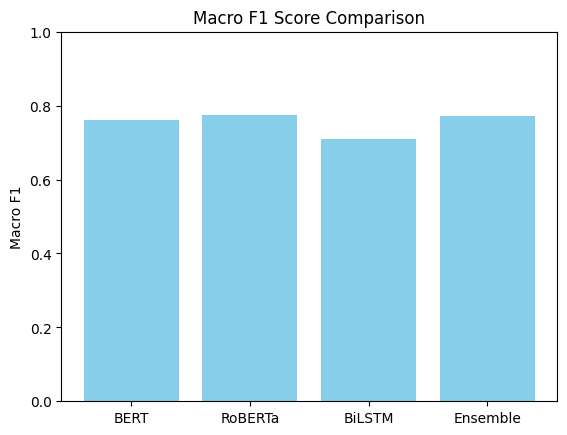

In [ ]:
model_names = ["BERT", "RoBERTa", "BiLSTM", "Ensemble"]
f1_scores = [
    f1_score(y_val, y_pred_bert, average='macro'),
    f1_score(y_val, y_pred_roberta, average='macro'),
    f1_score(y_val, y_pred_labels_lstm, average='macro'),
    f1_score(y_val, ensemble_preds, average='macro'),
]

import matplotlib.pyplot as plt
plt.bar(model_names, f1_scores, color='skyblue')
plt.title("Macro F1 Score Comparison")
plt.ylabel("Macro F1")
plt.ylim(0, 1)
plt.show()


# **Ensemble Predictions on testset-levela.tsv**

In [ ]:
# Load test set
test_df = pd.read_csv("testset-levela.tsv", sep="\t", names=["id", "tweet"], skiprows=1)

# Apply the same cleaning used during training
test_df["clean_tweet"] = test_df["tweet"].apply(clean_text)


In [ ]:
bert_inputs = tokenizer(
    test_df["clean_tweet"].tolist(),
    padding=True, truncation=True, max_length=128, return_tensors="tf"
)
bert_logits = model_bert.predict(bert_inputs)["logits"]
bert_preds = np.argmax(bert_logits, axis=1)


27/27 [==============================] - 11s 217ms/step


In [ ]:
roberta_inputs = roberta_tokenizer(
    test_df["clean_tweet"].tolist(),
    padding=True, truncation=True, max_length=128, return_tensors="tf"
)
roberta_logits = roberta_model.predict(roberta_inputs)["logits"]
roberta_preds = np.argmax(roberta_logits, axis=1)


27/27 [==============================] - 11s 211ms/step


In [ ]:
lstm_sequences = tokenizer_lstm.texts_to_sequences(test_df["clean_tweet"])
lstm_padded = pad_sequences(lstm_sequences, maxlen=128, padding='post', truncating='post')
lstm_probs = model_lstm.predict(lstm_padded)
lstm_preds = np.argmax(lstm_probs, axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
from scipy.stats import mode

# Stack and vote
stacked_test_preds = np.vstack([bert_preds, roberta_preds, lstm_preds])
ensemble_test_preds = mode(stacked_test_preds, axis=0, keepdims=False)[0]


In [ ]:
# Convert back to original label names
id_to_label = {0: "NOT", 1: "OFF"}
test_df["label"] = [id_to_label[p] for p in ensemble_test_preds]

# Save to CSV
test_df[["id", "label"]].to_csv("final_predictions.csv", index=False)

print("✅ Ensemble predictions saved to final_predictions.csv!")


✅ Ensemble predictions saved to final_predictions.csv!


# **Evaluation on test-set**

In [ ]:
# Load predictions
preds_df = pd.read_csv("final_predictions.csv")

# Load gold labels (no header)
gold_df = pd.read_csv("labels-levela.csv", names=["id", "gold_label"])


In [ ]:
# Merge on ID
merged_df = preds_df.merge(gold_df, on="id")

# Encode labels for comparison
label_to_id = {"NOT": 0, "OFF": 1}
y_true = merged_df["gold_label"].map(label_to_id).values
y_pred = merged_df["label"].map(label_to_id).values


Classification Report:
              precision    recall  f1-score   support

         NOT       0.87      0.92      0.90       620
         OFF       0.77      0.64      0.70       240

    accuracy                           0.84       860
   macro avg       0.82      0.78      0.80       860
weighted avg       0.84      0.84      0.84       860

Macro F1 Score : 0.7953835227272728


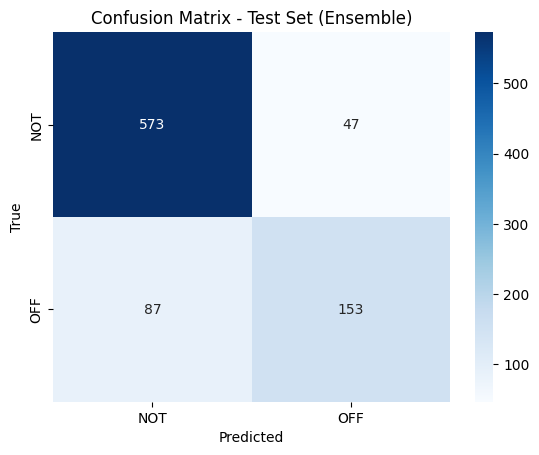

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["NOT", "OFF"]))
print("Macro F1 Score :", f1_score(y_true, y_pred, average='macro'))

# Optional: confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NOT", "OFF"], yticklabels=["NOT", "OFF"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set (Ensemble)")
plt.show()
